# Associative Memory

This tutorial introduces the Associative Memory (AM) module in the SPA.

Associative memory is a neural network used to store and recall patterns.
When the input of the network is presented with a partial or noisy pattern, it can either recover the very same pattern or recall another stored pattern. 
If the recovered pattern is the same as the input pattern, the memory is said to be autoassociative or "clean-up" memory. Otherwise, if the recovered pattern is different from the presented one the network is heteroassociative. 
For more information on properties and storage capacities of associative memories see X, Y and Z.

Patterns stored by the AM module in the SPA are semantic pointers, organised in a SPA vocabulary.
The examples in this tutorial demonstrate how to use the AM module, store and recall the patterns.
Advanced functionality of the module such as the recall of multiple memories similar to the input are also presented.

In [94]:
# python libraries and plotting tools
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import nengo
from nengo import spa
%load_ext nengo.ipynb

The nengo.ipynb extension is already loaded. To reload it, use:
  %reload_ext nengo.ipynb


## Step 1: Creating an Associative Memory

We start by creating a set of patterns the AM will store. 
The vocabulary in this example contains five words: ORANGE, APRICOT, CHERRY, STRAWBERRY and APPLE.
Each word is represented as a semantic pointer, a $n$-dimensional vector.
When creating a vocabulary, we specify the number of dimensions for all semantic pointers.
Then, we add the words to a vocabulary using the method `parse`.

In [95]:
vocab = spa.Vocabulary(dimensions=16)

words = ['ORANGE', 'APRICOT', 'CHERRY', 'STRAWBERRY', 'APPLE']

for word in words:
    vocab.parse(word)

Next, we create an autoassociative memory with a corresponding set of pattern it represents.
The memory is created within a `nengo.Network` module.

In [96]:
with nengo.Network('model', seed=1) as model:
    assoc_mem = spa.AssociativeMemory(input_vocab=vocab)

After the network has been created, we can test its functionality by presenting a semantic pointer at the input and comparing it with a semantic pointer at the output after running a simulation. If the similarity between the output vector and the input vector is close to one, we can say that the associative memory successfully recovered the pattern.
To achieve this, we need to introduce two additional objects: `nengo.Node` and `nengo.Probe`. The `nengo.Node` object provides input to the associative memory. 
`nengo.Probe` is used to gather simulation data, in our case the input being fed to the network (input pattern) and the network output (output pattern) at every simulation time step.
In this example, the input to the network is the semantic pointer 'APPLE':

In [97]:
with model:
    input_vector = vocab['APPLE'].v
    input_node = nengo.Node(output=input_vector, label='input')
    
    nengo.Connection(input_node, assoc_mem.input)

    input_probe = nengo.Probe(input_node)
    output_probe = nengo.Probe(assoc_mem.output, synapse=0.03)

We run the simulation for the 0.2 simulation time:

In [98]:
sim = nengo.Simulator(model)
sim.run(0.2)
t = sim.trange()
print('Number of simulation steps: %d' % len(t))

Number of simulation steps: 200


We use the probes to get the data produced by the simulation:

In [99]:
input_net = sim.data[input_probe]
output_net = sim.data[output_probe]
print("Input dimensions: (%d, %d)" % input_net.shape)
print("Output dimensions: (%d, %d)" % output_net.shape)

Input dimensions: (200, 16)
Output dimensions: (200, 16)


We see that for each simulation step (rows of the `input_net` and the `output_net` arrays) there is a 16-dimensional pattern represented in the associative memory. 
We use a dot product to compare the similarity of inputs and outputs to all patterns in the vocabulary.

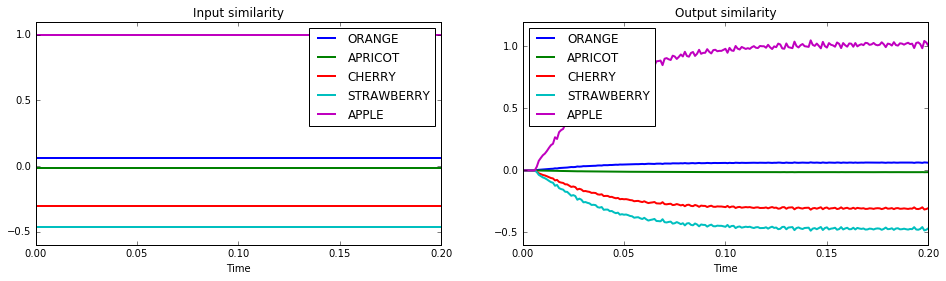

In [100]:
def plot_similarities(input_net, output_net, vocab1, vocab2=None):
    if vocab2 is None:
        vocab2 = vocab1

    plt.figure(figsize=(16, 4))
    plt.subplot(1, 2, 1)
    plt.plot(t, nengo.spa.similarity(input_net, vocab1), lw=2)
    plt.title("Input similarity")
    plt.xlabel('Time')
    plt.ylim(top=1.1)
    plt.legend(vocab1.keys, loc='best')
    plt.subplot(1, 2, 2)
    plt.plot(t, nengo.spa.similarity(output_net, vocab2), lw=2)
    plt.title("Output similarity")
    plt.xlabel('Time')
    plt.legend(vocab2.keys, loc='best')
    
plot_similarities(input_net, output_net, vocab)


We see that the network input has been constant throughout the simulation (`APPLE=1`). Notice that there is some small similarity between the pattern `APPLE` and patterns `STRAWBERRY` and `CHERRY`. This is because the semantic pointers are not orthogonal. 
The similarity of the semantic pointer at the output of the network with the semantic pointer `APPLE` increases until it reaches a maximal value (`=1`). This means that the associative memory successfully retrieved the pattern at the input. The exponential increase is due to the synaptic filtering in `nengo.Probe`. This is used to show how the input to another group of neurons connected to the output of this particular AM module would look like.


## Step 3: Memory clean-up


In the next example we show the ability of the associative memory to retrieve a noisy pattern. 
This is a very common use of autoassociative memories, also called the "clean-up" feature as the AM removes the noise in the input.

Now, instead of presenting just one semantic pointer from a vocabulary, we present a combination of several semantic pointers. This is still one single vector, which is mostly similar to one semantic pointer but is also somewhat similar to other semantic pointers. Therefore, as the input is not "clean" we can say that we are presenting a noisy pattern.
The effect would have been similar if we had chosen randomly distributed numbers using, for example, `numpy`'s `random.rand` function. To indicate that the output of the AM should be similar to just one stored vector, we set the parameter `wta_output` to `True`. `WTA` is a computational principle called winner-take-all, stating that one, mostly active element should be regarded as the winner among possible, less active alternatives.

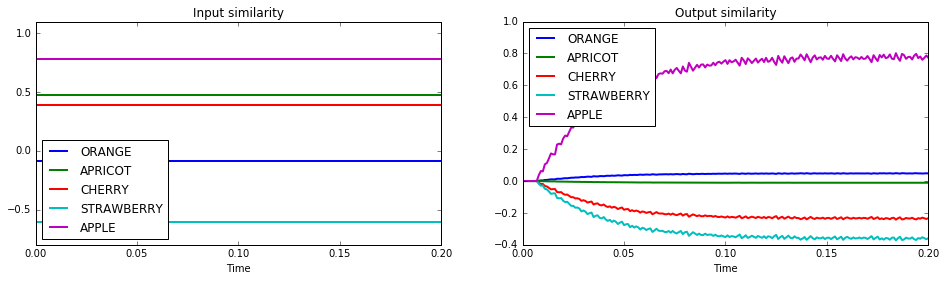

In [101]:
with model:
    assoc_mem = spa.AssociativeMemory(input_vocab=vocab, wta_output=True)
    
    input_vector = vocab['APPLE'].v + 0.7*vocab['CHERRY'].v + 0.5*vocab['APRICOT'].v
    input_node = nengo.Node(output=input_vector, label='input')
    nengo.Connection(input_node, assoc_mem.input)

    input_probe = nengo.Probe(input_node)
    output_probe = nengo.Probe(assoc_mem.output, synapse=0.03)

sim = nengo.Simulator(model)
sim.run(0.2)
t = sim.trange()

input_net = sim.data[input_probe]
output_net = sim.data[output_probe]

plot_similarities(input_net, output_net, vocab)


We can see that the input presented to the network is mostly similar to the semantic pointer "APPLE", but it is also similar to other semantic pointers in the vocabulary. 
We see that the network output is very similar to the pattern `APPLE`.

Another feature of the AM module is thresholding of the inputs. By specifying a threshold, the output will be similar only to those inputs whose similarity with a vocabulary item is above a certain value.

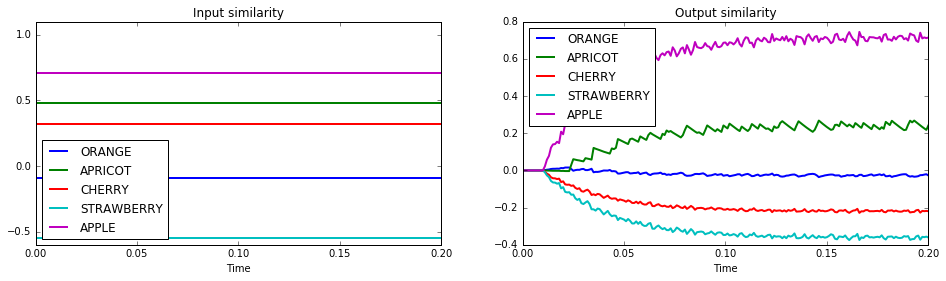

In [102]:
with nengo.Network('model', seed=1) as model:
    assoc_mem = spa.AssociativeMemory(input_vocab=vocab, threshold=0.4)
    
    input_vector = 0.9*vocab['APPLE'].v + 0.6*vocab['CHERRY'].v + 0.5*vocab['APRICOT'].v
    input_node = nengo.Node(output=input_vector, label='input')
    nengo.Connection(input_node, assoc_mem.input)

    input_probe = nengo.Probe(input_node)
    output_probe = nengo.Probe(assoc_mem.output, synapse=0.03)

sim = nengo.Simulator(model)
sim.run(0.2)
t = sim.trange()

input_net = sim.data[input_probe]
output_net = sim.data[output_probe]

plot_similarities(input_net, output_net, vocab)

The similarity of the input with the semantic pointer `APPLE` is slightly above 0.6, 0.5 with `APRICOT` and slightly below 0.2 for `CHERRY`. We have specified the threshold of `0.4` which means that the resulting output vector will be similar to `APPLE` and `APRICOT` at their similarity with the input is greater than 0.4

## Step 2: Hetero-associative relationships

To model a variety of interesting memory phenomena, it is often useful to store relationships between different sets of patterns.
For example, to simulate number counting from 1 to 5, the memory needs to store the relationships between patterns representing numbers:
$1\rightarrow2, 2\rightarrow3, 3\rightarrow4, 4\rightarrow5$

In this example we show how to use `spa.AssociativeMemory` to this task. In order to achieve the number counting we will split the task into two parts:

1. Present a number at the input and recall a number obtained by adding one to the input (e.g. for `1` recall `2`, for `2` recall `3` etc). This corresponds to hetero-associative mapping.
    
2. Feed the output of the associative memory to its input.

    
As in the previous example, we start by defining a vocabulary that stores semantic pointes representing five numbers. This will be used as the input and as the output vocabulary. In case of hetero-associative memories the input and the output vocabulary can differ. Because we want to achieve a hetero-associative mapping, we need to spacify which input patterns map to which output patterns. The desired mapping in specified by providing `input_keys` and `output_keys`:

In [107]:
n_dim = 16
vocab = spa.Vocabulary(dimensions=n_dim)

# a quicker way to add words to a vocabulary
vocab.parse('ONE + TWO + THREE + FOUR + FIVE')

# from patterns
input_keys = ['ONE', 'TWO', 'THREE', 'FOUR']

# to patterns
output_keys = ['TWO', 'THREE', 'FOUR', 'FIVE']

Now we use a Nengo's feature that allows us to pass a function as the input to a `Node`. 
By passing a function we can specify which semantic pointer is going to be present at the input at certain simulation time point. We choose to present the semantic pointer `ONE` for the similation times between 0 and 0.2, `TWO` for times between 0.2 and 0.4 etc.

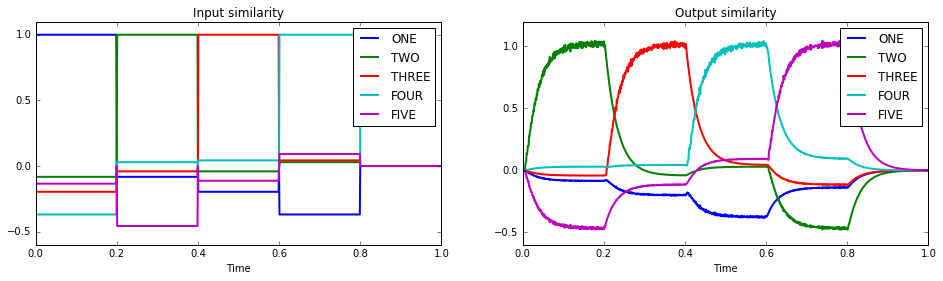

In [108]:
def input_fun(t):
    if 0 < t < 0.2:
        return vocab['ONE'].v
    elif 0.2 < t < 0.4:
        return vocab['TWO'].v
    elif 0.4 < t < 0.6:
        return vocab['THREE'].v
    elif 0.6 < t < 0.8:
        return vocab['FOUR'].v
    else:
        return np.zeros(n_dim)

with nengo.Network('model', seed=1) as model:
    assoc_mem = spa.AssociativeMemory(input_vocab=vocab, output_vocab=vocab,
                                      input_keys=input_keys, output_keys=output_keys)
    
    input_node = nengo.Node(output=input_fun, label='input')
    nengo.Connection(input_node, assoc_mem.input)

    input_probe = nengo.Probe(input_node)
    output_probe = nengo.Probe(assoc_mem.output, synapse=0.03)
    
sim = nengo.Simulator(model)
sim.run(1.)
t = sim.trange()

input_net = sim.data[input_probe]
output_net = sim.data[output_probe]

plot_similarities(input_net, output_net, vocab)

The functionality achieved so far is addition by one. To achieve counting, we need to introduce a recurrent connection. That is, the network output needs to be fed into its input at the next time step. 
This will produce a sequence of numbers. This can be easily achieved in Nengo by adding just one additional connection and initialising the simulation by presenting the semantic pointer `ONE` at the input for a few steps. 

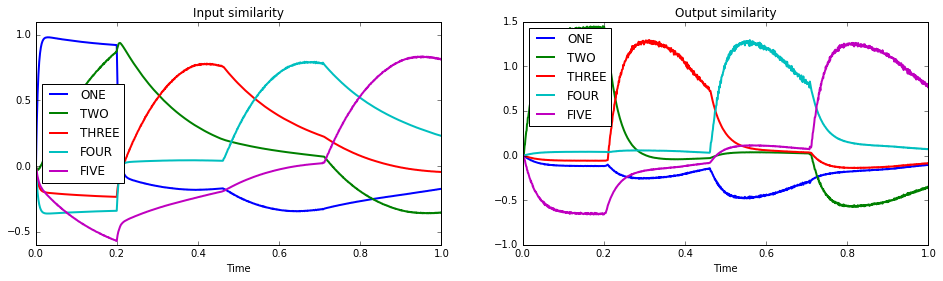

In [117]:
def input_fun(t):
    if 0 < t < 0.2:
        return vocab['ONE'].v
    else:
        return np.zeros(n_dim)

with nengo.Network('model', seed=3) as model:
    assoc_mem = spa.AssociativeMemory(input_vocab=vocab, output_vocab=vocab,
                                      input_keys=input_keys, output_keys=output_keys, 
                                      wta_output=True,
                                      input_scale=3)
    
    input_node = nengo.Node(output=input_fun, label='input')

    nengo.Connection(assoc_mem.output, assoc_mem.input, synapse=.18)
    nengo.Connection(input_node, assoc_mem.input)

    input_probe = nengo.Probe(assoc_mem.input)
    output_probe = nengo.Probe(assoc_mem.output, synapse=0.03)
    
sim = nengo.Simulator(model)
sim.run(1.)
t = sim.trange()

input_net = sim.data[input_probe]
output_net = sim.data[output_probe]

plot_similarities(input_net, output_net, vocab)